In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math

from pydtmc import MarkovChain

from ipywidgets import interact, Dropdown


DATA_DIR = 'data'

# Preprocessing

In [2]:
# Create mapping course_id -> course name/short name

class SmartMap(dict):
    def __missing__(self, key):
        return f"Unknown({key})"
    
course_map = SmartMap({
    42 : 'Langzeitgymnasium maths',
    3865 : 'Kurzzeitgymnasium maths',
    5447 : 'Langzeitgymnasium essay',
    2115 : 'Langzeitgymnasium text comprehension',
    5009 : 'Kurzzeitgymnasium text comprehension',
    3301 : 'Kurzzeitgymnasium essay',
    1696 : 'Student site introduction',
    8117 : 'Teacher site introduction'
})

course_map_short = SmartMap({
    42 : 'LZG_M',
    3865 : 'KZG_M',
    5447 : 'LZG_E',
    2115 : 'LZG_TC',
    5009 : 'KZG_TC',
    3301 : 'KZG_E',
    1696 : 'SSI',
    8117 : 'TSI'
})

In [3]:
# Utility function
def get_info(df):
    if 'user_id' in df:
        print(f"Unique users: {len(df['user_id'].unique())}")
    print(f"Unique activities: {df.shape[0]}")

In [4]:
# Get activity data
activities = pd.read_csv(f'{DATA_DIR}/activity.csv')

get_info(activities)

# Drop activities without beginning if any
activities = activities.dropna(subset='activity_started')

get_info(activities)

# Drop irrelevant activity types
activities = activities[~activities['activity_type'].isin(['exam','group_progress','access'])]
activities.sort_values(by=['user_id', 'activity_started'], ascending=True, inplace=True)

get_info(activities)


Unique users: 1146
Unique activities: 72897
Unique users: 1146
Unique activities: 72897
Unique users: 815
Unique activities: 69456


In [5]:
# Cast timestamps to datetime
activities['activity_started'] = pd.to_datetime(activities['activity_started'], unit='s')
activities['activity_completed'] = pd.to_datetime(activities['activity_completed'], unit='s')
activities['activity_updated'] = pd.to_datetime(activities['activity_updated'], unit='s')

# Remove entries where the activity_completed was before the activity_started
activities = activities[activities['activity_completed'] > activities['activity_started']]

# Create a column with the duration of the activity
activities['activity_duration'] = activities['activity_completed'] - activities['activity_started']
activities['activity_duration_minutes'] = activities['activity_duration'].dt.total_seconds() / 60

# Remove entries where the activity_completed is more than 24 hours after the activity_started
activities = activities[activities['activity_duration_minutes'] <= 24 * 60]

In [6]:
print(f"Verify no NaN durations: {activities.activity_duration.isna().sum()}")
get_info(activities)


Verify no NaN durations: 0
Unique users: 743
Unique activities: 25833


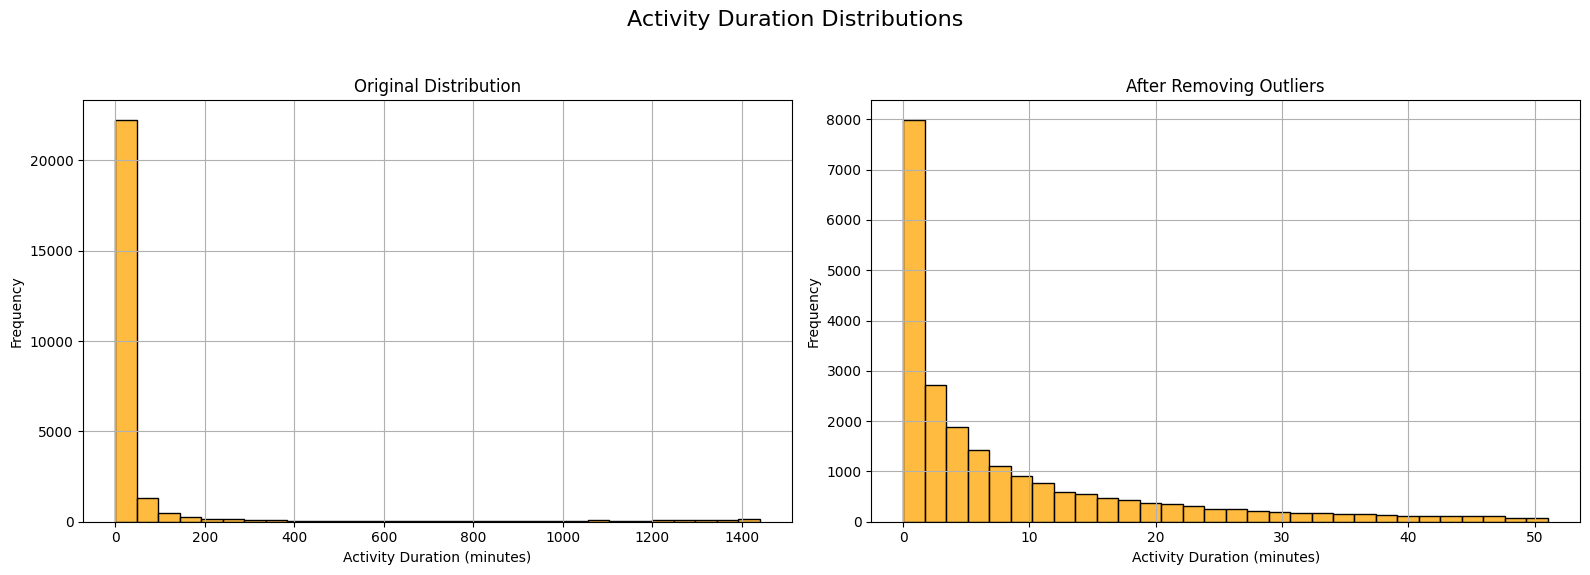

In [7]:
# Compute IQR bounds for filtering
Q1 = activities['activity_duration_minutes'].quantile(0.25)
Q3 = activities['activity_duration_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Activity Duration Distributions", fontsize=16)

# Before filtering
sns.histplot(activities['activity_duration_minutes'], bins=30, color='orange', ax=axes[0])
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Activity Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].grid()

# Filter outliers
activities = activities[
    (activities['activity_duration_minutes'] >= lower_bound) &
    (activities['activity_duration_minutes'] <= upper_bound)
]

# After filtering
sns.histplot(activities['activity_duration_minutes'], bins=30, color='orange', ax=axes[1])
axes[1].set_title('After Removing Outliers')
axes[1].set_xlabel('Activity Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:

# Build activity_state = (activity_type, course_id) and log durations where possible
activities['activity_state'] = activities['activity_type'] + '_' + activities['course_id'].map(course_map_short).fillna('Unknown')


# Index states numerically
state_to_idx = {s: i for i, s in enumerate(activities['activity_state'].unique())}
activities['state_idx'] = activities['activity_state'].map(state_to_idx)

# Log subsequent states into a separate column
activities['next_state_idx'] = activities.groupby('user_id')['state_idx'].shift(-1)
transitions = activities.dropna(subset=['next_state_idx']).copy()
transitions['next_state_idx'] = transitions['next_state_idx'].astype(int)

print("Transitions info:")
get_info(transitions)


all_states = activities['activity_state'].unique().tolist()
n_states = len(all_states)


Transitions info:
Unique users: 703
Unique activities: 21613


In [9]:
durations = activities.groupby('activity_state')['activity_duration'].apply(lambda x: x.dropna().tolist()).reset_index()


print(f"Number of states before: {len(durations.activity_state)}")

# Define threshold
threshold = 10

# Keep only states with enough data and only median as sufficient information
final_durations = durations[durations['activity_duration'].apply(len) > threshold].copy()
final_durations['median_duration'] = final_durations['activity_duration'].apply(np.median)

final_durations = final_durations[['activity_state', 'median_duration']]
final_durations = final_durations.sort_values('median_duration')


print(f"Number of states after: {len(final_durations.activity_state)}")
print("States where sufficient data on activity_duration is available:")
for activity_state in final_durations.activity_state:
    print(activity_state)



Number of states before: 23
Number of states after: 21
States where sufficient data on activity_duration is available:
topic_TSI
topic_SSI
topic_LZG_TC
topic_LZG_M
quiz_LZG_E
topic_KZG_TC
lesson_LZG_TC
quiz_KZG_E
topic_KZG_M
quiz_LZG_M
topic_LZG_E
lesson_TSI
lesson_SSI
topic_KZG_E
lesson_KZG_M
quiz_KZG_M
lesson_LZG_E
lesson_LZG_M
lesson_KZG_TC
course_SSI
lesson_KZG_E


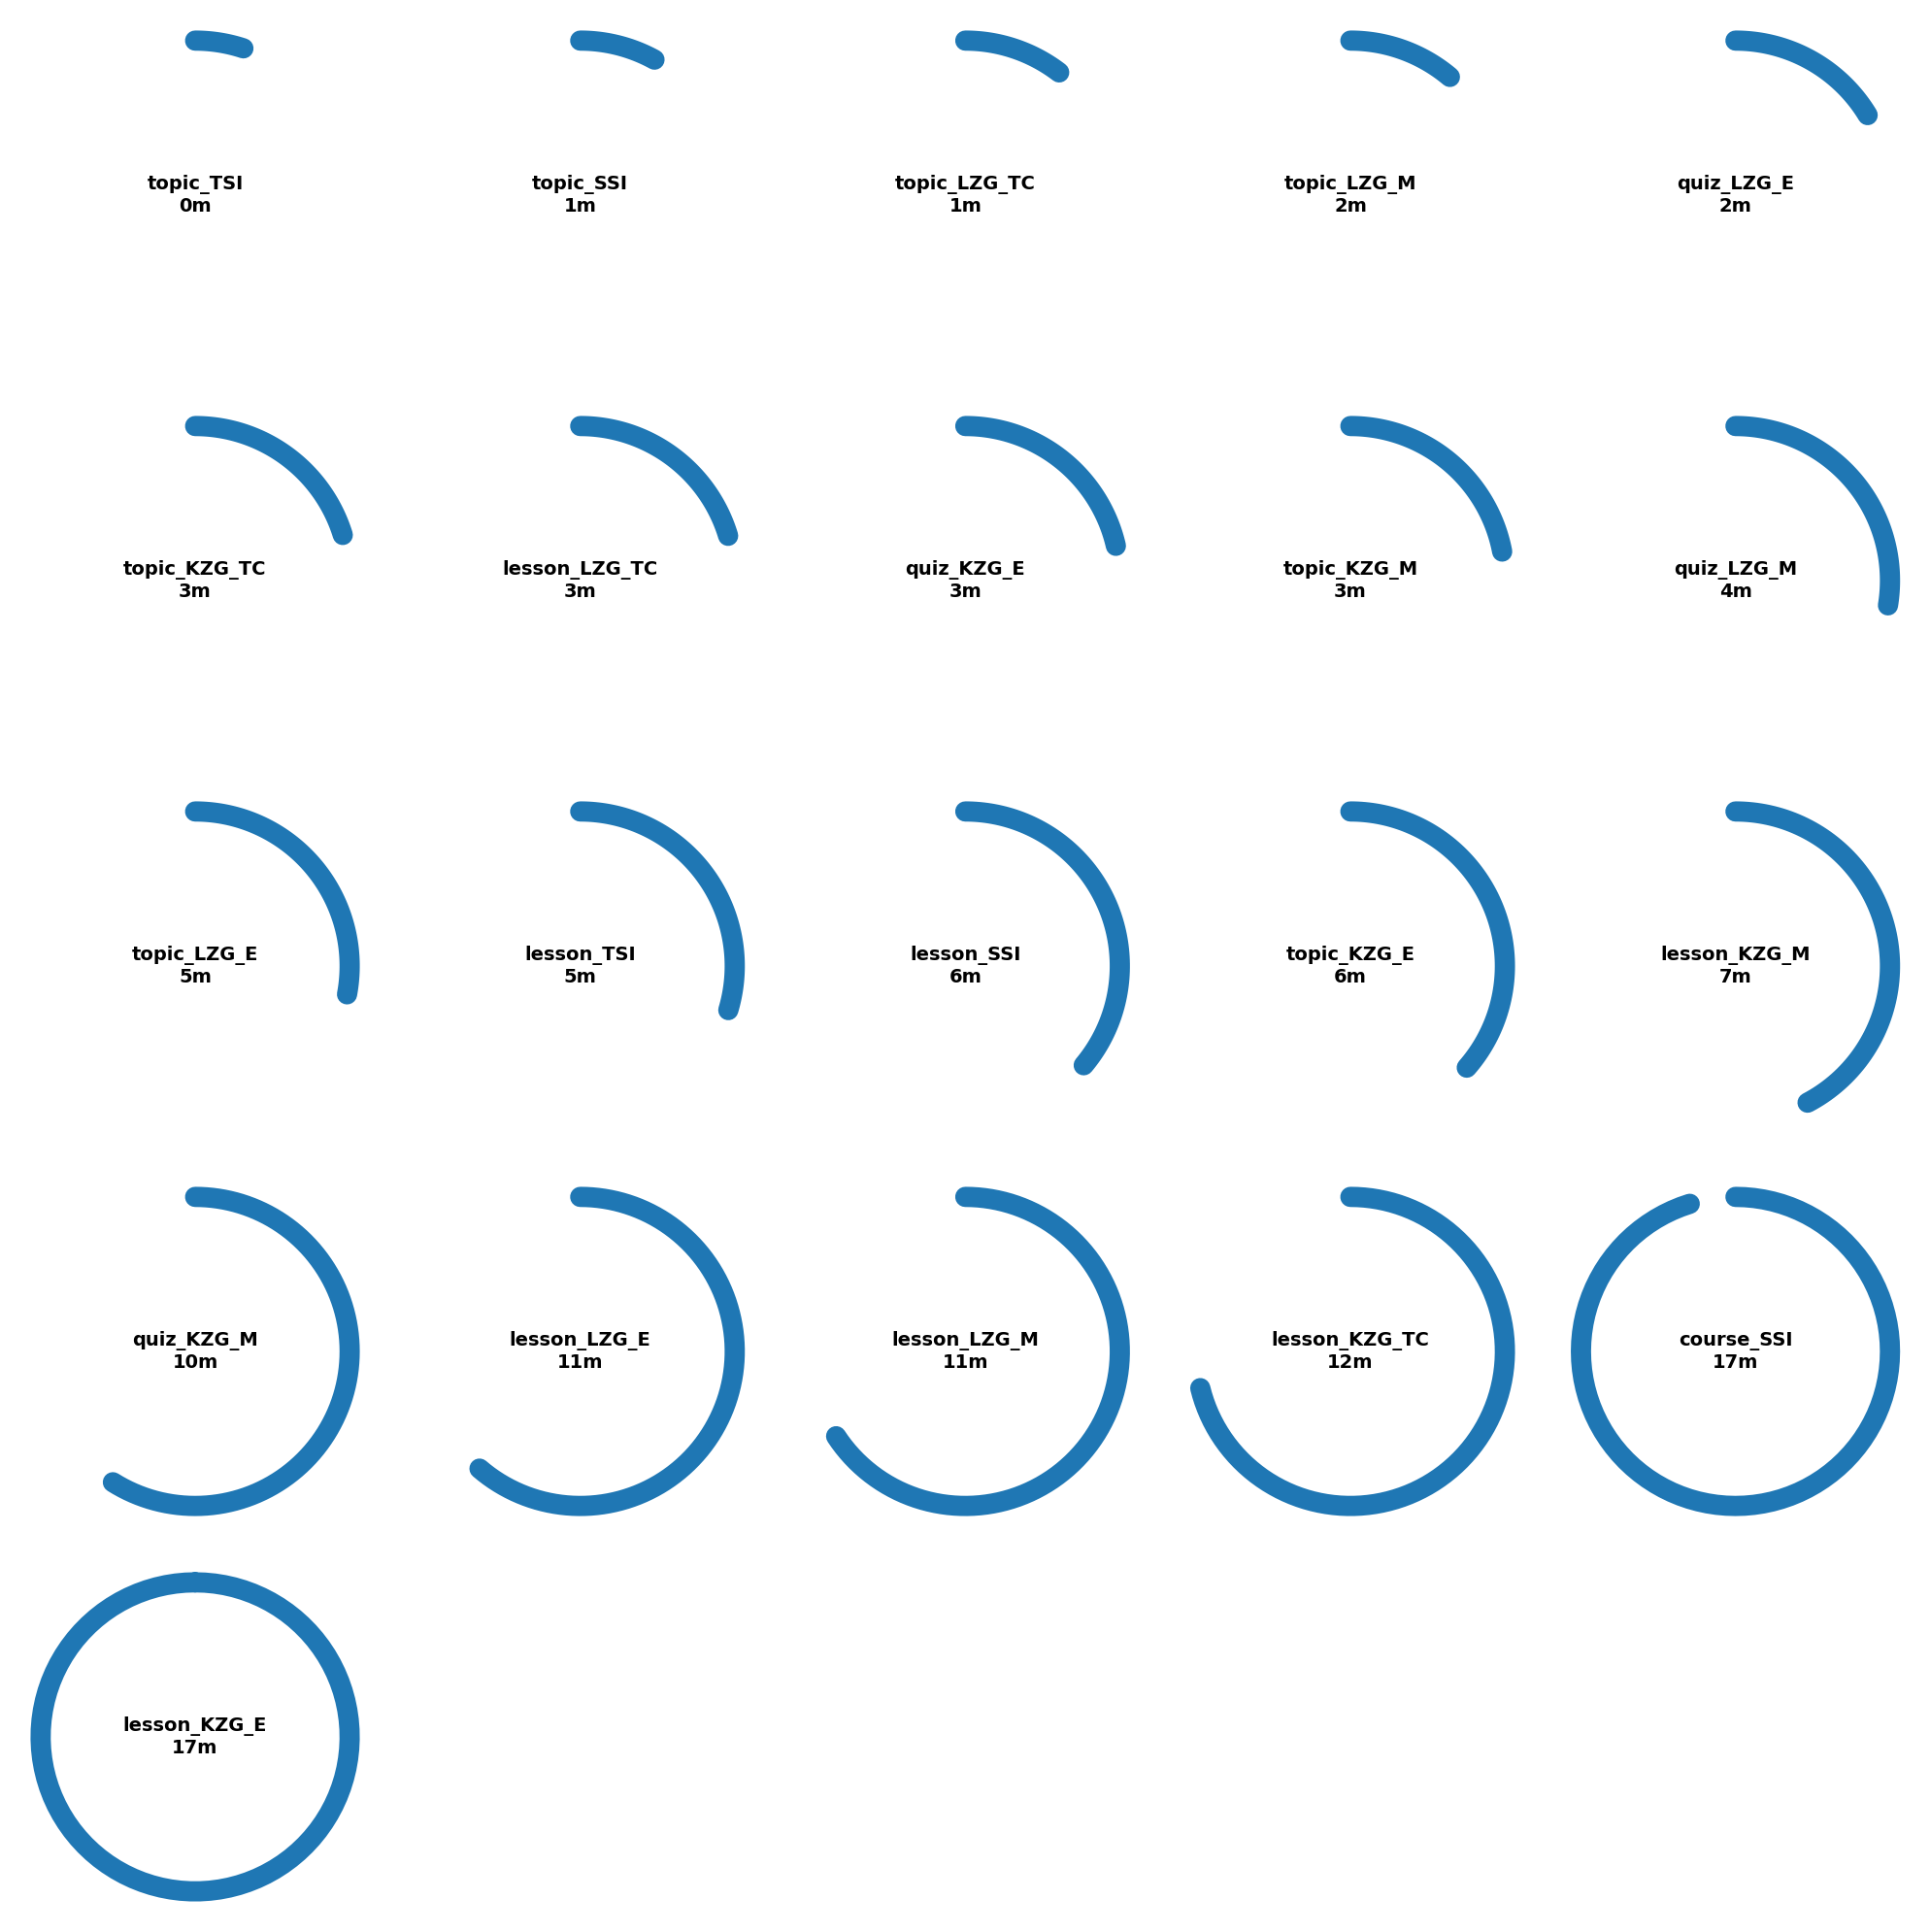

In [10]:
# Convert median_duration to total minutes
final_durations['duration_minutes'] = final_durations['median_duration'].dt.total_seconds() / 60

max_duration = final_durations['duration_minutes'].max()

def format_duration(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    if hours > 0:
        return f"{hours}h {mins}m" if mins > 0 else f"{hours}h"
    else:
        return f"{mins}m"

# Determine grid size
n = len(final_durations)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)

# Plotting settings
fig, axes = plt.subplots(
    rows, cols, 
    figsize=(cols * 4, rows * 4), 
    subplot_kw={'projection': 'polar'}
)

# Flatten axes array for easy iteration
axes = np.array(axes).flatten()

for ax, (idx, row) in zip(axes, final_durations.iterrows()):
    activity = row['activity_state']
    duration = row['duration_minutes']
    proportion = duration / max_duration
    
    theta = np.linspace(0, 2 * np.pi * proportion, 100)
    ax.plot(theta, [1]*len(theta), linewidth=15, solid_capstyle='round')
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_ylim(0, 1.2)
    ax.axis('off')
    
    ax.text(
        0, 0, 
        f"{activity}\n{format_duration(duration)}", 
        ha='center', va='center', fontsize=14, weight='bold'
    )

# Hide unused axes if any
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [11]:
final_durations.dtypes

activity_state               object
median_duration     timedelta64[ns]
duration_minutes            float64
dtype: object

In [12]:
activities.dtypes

Unnamed: 0                             int64
activity_id                            int64
user_id                                int64
post_id                                int64
course_id                              int64
activity_type                         object
activity_status                        int64
activity_started              datetime64[ns]
activity_completed            datetime64[ns]
activity_updated              datetime64[ns]
activity_duration            timedelta64[ns]
activity_duration_minutes            float64
activity_state                        object
state_idx                              int64
next_state_idx                       float64
dtype: object

In [ ]:
import pandas as pd

def compute_learning_speed(user_data: pd.DataFrame, global_median: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the normalized learning speed metric per user.

    Parameters:
    - user_data: DataFrame with columns ['user_id', 'activity_state', 'activity_duration'] (timedelta64).
    - global_median: DataFrame with columns ['activity_state', 'median_duration'] (timedelta64).

    Returns:
    - DataFrame with ['user_id', 'final_learning_speed'] where values are in [0, 1], higher is faster.
    """
    total_states = global_median['activity_state'].nunique()

    # Compute per-user, per-state median durations
    user_state_medians = (
        user_data
        .groupby(['user_id', 'activity_state'])['activity_duration']
        .median()
        .reset_index()
    )

    # Merge with global medians
    merged = user_state_medians.merge(global_median, on='activity_state')

    # Compute duration ratio and learning speed
    merged['duration_ratio'] = merged['activity_duration'] / merged['median_duration']
    merged['learning_speed'] = 1 / (1 + merged['duration_ratio'])

    # Compute learning speed sum and number of states experienced per user
    user_scores = merged.groupby('user_id').agg(
        learning_speed_sum=('learning_speed', 'sum'),
        states_experienced=('activity_state', 'nunique')
    ).reset_index()

    # Apply normalization adjusted for missing states (assuming avg speed = 0.5 for missing states)
    user_scores['final_learning_speed'] = (
        (user_scores['learning_speed_sum'] + 0.5 * (total_states - user_scores['states_experienced'])) 
        / total_states
    )

    return user_scores[['user_id', 'final_learning_speed']]


In [14]:
learning_speeds = compute_learning_speed(activities, final_durations)
learning_speeds

,user_id,final_learning_speed
0,1,0.523862
1,4,0.515754
2,6,0.470716
3,7,0.436891
4,9,0.486663
...,...,...
728,4087,0.490538
729,4089,0.467409
730,4090,0.464494
731,4092,0.538495


In [15]:
activities['activity_type'].unique()

array(['quiz', 'topic', 'lesson', 'course'], dtype=object)

In [16]:
transitions

,Unnamed: 0,activity_id,user_id,post_id,course_id,activity_type,activity_status,activity_started,activity_completed,activity_updated,activity_duration,activity_duration_minutes,activity_state,state_idx,next_state_idx
36137,538,80399,1,13425,3301,quiz,1,2024-11-02 01:42:10,2024-11-02 01:47:09,2024-11-02 01:47:09,0 days 00:04:59,4.983333,quiz_KZG_E,0,1
45192,389,89470,1,5083,5009,topic,1,2024-11-25 16:29:55,2024-11-25 17:02:36,2024-11-25 17:02:36,0 days 00:32:41,32.683333,topic_KZG_TC,1,1
45206,403,89484,1,5085,5009,topic,1,2024-11-25 17:02:37,2024-11-25 17:12:14,2024-11-25 17:12:14,0 days 00:09:37,9.616667,topic_KZG_TC,1,1
47334,387,91612,1,5097,5009,topic,1,2024-11-29 22:44:08,2024-11-29 22:44:39,2024-11-29 22:44:39,0 days 00:00:31,0.516667,topic_KZG_TC,1,1
47335,388,91613,1,5099,5009,topic,1,2024-11-29 22:44:40,2024-11-29 22:44:59,2024-11-29 22:44:59,0 days 00:00:19,0.316667,topic_KZG_TC,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48050,392,92329,4095,6690,3865,topic,1,2024-12-02 16:43:22,2024-12-02 17:18:07,2024-12-02 17:18:07,0 days 00:34:45,34.750000,topic_KZG_M,3,3
48051,393,92330,4095,6663,3865,topic,1,2024-12-02 16:43:32,2024-12-02 16:51:12,2024-12-02 16:51:12,0 days 00:07:40,7.666667,topic_KZG_M,3,4
48266,608,92545,4095,6488,3865,quiz,1,2024-12-03 13:16:37,2024-12-03 13:23:13,2024-12-03 13:23:13,0 days 00:06:36,6.600000,quiz_KZG_M,4,4
48272,614,92551,4095,6529,3865,quiz,1,2024-12-03 13:23:56,2024-12-03 13:30:57,2024-12-03 13:30:57,0 days 00:07:01,7.016667,quiz_KZG_M,4,4


In [17]:
activities

,Unnamed: 0,activity_id,user_id,post_id,course_id,activity_type,activity_status,activity_started,activity_completed,activity_updated,activity_duration,activity_duration_minutes,activity_state,state_idx,next_state_idx
36137,538,80399,1,13425,3301,quiz,1,2024-11-02 01:42:10,2024-11-02 01:47:09,2024-11-02 01:47:09,0 days 00:04:59,4.983333,quiz_KZG_E,0,1.0
45192,389,89470,1,5083,5009,topic,1,2024-11-25 16:29:55,2024-11-25 17:02:36,2024-11-25 17:02:36,0 days 00:32:41,32.683333,topic_KZG_TC,1,1.0
45206,403,89484,1,5085,5009,topic,1,2024-11-25 17:02:37,2024-11-25 17:12:14,2024-11-25 17:12:14,0 days 00:09:37,9.616667,topic_KZG_TC,1,1.0
47334,387,91612,1,5097,5009,topic,1,2024-11-29 22:44:08,2024-11-29 22:44:39,2024-11-29 22:44:39,0 days 00:00:31,0.516667,topic_KZG_TC,1,1.0
47335,388,91613,1,5099,5009,topic,1,2024-11-29 22:44:40,2024-11-29 22:44:59,2024-11-29 22:44:59,0 days 00:00:19,0.316667,topic_KZG_TC,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48051,393,92330,4095,6663,3865,topic,1,2024-12-02 16:43:32,2024-12-02 16:51:12,2024-12-02 16:51:12,0 days 00:07:40,7.666667,topic_KZG_M,3,4.0
48266,608,92545,4095,6488,3865,quiz,1,2024-12-03 13:16:37,2024-12-03 13:23:13,2024-12-03 13:23:13,0 days 00:06:36,6.600000,quiz_KZG_M,4,4.0
48272,614,92551,4095,6529,3865,quiz,1,2024-12-03 13:23:56,2024-12-03 13:30:57,2024-12-03 13:30:57,0 days 00:07:01,7.016667,quiz_KZG_M,4,4.0
48290,632,92569,4095,6307,3865,quiz,1,2024-12-03 13:37:53,2024-12-03 13:48:38,2024-12-03 13:48:38,0 days 00:10:45,10.750000,quiz_KZG_M,4,4.0


In [18]:
learning_speeds

,user_id,final_learning_speed
0,1,0.523862
1,4,0.515754
2,6,0.470716
3,7,0.436891
4,9,0.486663
...,...,...
728,4087,0.490538
729,4089,0.467409
730,4090,0.464494
731,4092,0.538495


In [19]:
final_transitions = transitions[['user_id', 'activity_state', 'state_idx', 'next_state_idx']]
final_transitions

,user_id,activity_state,state_idx,next_state_idx
36137,1,quiz_KZG_E,0,1
45192,1,topic_KZG_TC,1,1
45206,1,topic_KZG_TC,1,1
47334,1,topic_KZG_TC,1,1
47335,1,topic_KZG_TC,1,1
...,...,...,...,...
48050,4095,topic_KZG_M,3,3
48051,4095,topic_KZG_M,3,4
48266,4095,quiz_KZG_M,4,4
48272,4095,quiz_KZG_M,4,4


In [20]:
# Per-user Markov chains
user_chains = {}

for user_id, group in final_transitions.groupby('user_id'):
    matrix = np.zeros((n_states, n_states), dtype=float)
    # Vectorized accumulation of transition counts
    np.add.at(matrix, (group['state_idx'], group['next_state_idx']), 1)
    
    # Normalize rows and handle dead-end states with self-loops
    row_sums = matrix.sum(axis=1, keepdims=True)
    for idx, row_sum in enumerate(row_sums.flatten()):
        if row_sum == 0:
            matrix[idx, idx] = 1  # Self-loop
        else:
            matrix[idx] /= row_sum  # Normalize row to sum to 1
    
    mc = MarkovChain(matrix.tolist(), all_states)
    user_chains[user_id] = mc

# ✅ Example: Inspect User 1's Model
print(f"User 1 Transition Matrix:\n{np.round(user_chains[1].p, 2)}")
print(f"States: {user_chains[1].states}")


User 1 Transition Matrix:
[[0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.9  0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.75 0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0. 

In [21]:
import ipywidgets as widgets
import networkx as nx
import plotly.graph_objs as go
from IPython.display import display
import numpy as np

def plot_user_markov_with_edge_labels(user_id):
    mc = user_chains[user_id]
    matrix = np.array(mc.p)
    states = mc.states

    # Identify non-trivial states
    non_trivial_states = set()
    for i, state in enumerate(states):
        row = matrix[i]
        col = matrix[:, i]
        if not (np.isclose(row[i], 1.0) and np.isclose(row.sum(), 1.0) and np.isclose(col.sum(), 1.0)):
            non_trivial_states.add(state)

    # Build filtered graph
    G = nx.DiGraph()
    for i, from_state in enumerate(states):
        if from_state not in non_trivial_states:
            continue
        for j, to_state in enumerate(states):
            if to_state in non_trivial_states and matrix[i, j] > 0:
                G.add_edge(from_state, to_state, weight=round(matrix[i, j], 2))

    if len(G.nodes) == 0:
        print(f"No significant transitions to visualize for User {user_id}.")
        return

    pos = nx.spring_layout(G, seed=42)  # Better separation

    edge_traces = []
    edge_annotations = []

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = edge[2]['weight']

        # Compute curvature offset
        offset = 0.1 if G.has_edge(edge[1], edge[0]) and edge[0] != edge[1] else 0
        ctrl_x = (x0 + x1) / 2 + offset * (y1 - y0)
        ctrl_y = (y0 + y1) / 2 + offset * (x0 - x1)

        curve_x = [x0, ctrl_x, x1]
        curve_y = [y0, ctrl_y, y1]

        edge_traces.append(go.Scatter(
            x=curve_x, y=curve_y,
            line=dict(width=2, color='gray', shape='spline'),
            mode='lines',
            hoverinfo='none'
        ))

        # Label near the curve's control point
        edge_annotations.append(dict(
            x=ctrl_x, y=ctrl_y,
            xref='x', yref='y',
            text=f"{weight}",
            showarrow=False,
            font=dict(color='black', size=14),
            bgcolor='rgba(255, 255, 255, 0.7)',
            bordercolor='black',
            borderwidth=1,
            borderpad=2,
            align='center',
            opacity=0.9
        ))

        # Arrow at the end
        edge_annotations.append(dict(
            ax=ctrl_x, ay=ctrl_y,
            x=x1, y=y1,
            axref='x', ayref='y',
            xref='x', yref='y',
            showarrow=True,
            arrowhead=3,
            arrowsize=2,
            arrowwidth=2,
            arrowcolor='gray',
            opacity=0.8
        ))

    # Node Trace
    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        text=list(G.nodes()),
        mode='markers+text',
        textposition='middle center',
        marker=dict(size=60, color='lightblue', line=dict(width=3, color='darkblue'))
    )

    fig = go.Figure(data=edge_traces + [node_trace],
                    layout=go.Layout(
                        title=f"User {user_id} Markov Model (Non-Trivial States)",
                        title_x=0.5,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(t=50, l=25, r=25, b=25),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        annotations=edge_annotations,
                        width=800,
                        height=600
                    ))
    fig.show()

# Interactive widget
user_selector = widgets.Dropdown(
    options=sorted(user_chains.keys()),
    description='User ID:',
    continuous_update=False
)

out = widgets.Output()

def on_user_change(change):
    with out:
        out.clear_output(wait=True)
        plot_user_markov_with_edge_labels(change['new'])

user_selector.observe(on_user_change, names='value')

display(user_selector, out)

# Auto-trigger initial plot
user_selector.value = sorted(user_chains.keys())[0]

Dropdown(description='User ID:', options=(1, 4, 6, 7, 9, 10, 11, 16, 17, 18, 19, 20, 22, 23, 26, 28, 29, 30, 3…

Output()

In [22]:
key_types = {type(k) for k in user_chains.keys()}
print("Key Types:", key_types)

# Get types of values
value_types = {type(v) for v in user_chains.values()}
print("Value Types:", value_types)

Key Types: {<class 'int'>}
Value Types: {<class 'pydtmc.markov_chain.MarkovChain'>}


In [23]:
user_daily_activity = activities.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

# Ceate a csv of user_ids, gap_days where gap_days is a list of the gaps (ignore nans) in increasing order. Use copies of the dataframes
df = user_daily_activity.copy(deep=True)[['user_id', 'gap_days']]
# Remove the first gap_days (nan) for each user
df.dropna(subset=['gap_days'], inplace=True)
# Group by user_id and aggregate the gap_days into a list
df = df.groupby('user_id')['gap_days'].apply(lambda x: list(x)).reset_index()
# Sort the gap_days list for each user
df['gap_days'] = df['gap_days'].apply(lambda x: sorted(x))

gap_days = df.copy(deep=True)

# Save to csv
gap_days.to_csv(f'{DATA_DIR}/user_gap_days.csv', index=False)

In [24]:
gap_days

,user_id,gap_days
0,1,"[1.0, 1.0, 2.0, 4.0, 4.0, 4.0, 7.0, 19.0, 23.0..."
1,4,"[2.0, 6.0, 7.0, 8.0, 13.0, 51.0]"
2,6,"[2.0, 2.0, 6.0, 6.0, 8.0, 14.0, 20.0, 44.0]"
3,7,"[1.0, 2.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 6.0, ..."
4,9,"[2.0, 7.0, 8.0, 12.0, 18.0, 24.0, 25.0]"
...,...,...
618,4087,"[1.0, 1.0, 2.0, 4.0, 5.0, 5.0, 11.0, 11.0, 12...."
619,4089,"[1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 5.0, 14.0]"
620,4090,"[1.0, 69.0]"
621,4092,"[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 4.0, ..."


In [25]:
all_scores = pd.read_csv((f'{DATA_DIR}/all_scores.csv'))
all_scores= all_scores[['user_id','percentage']].groupby('user_id', as_index=False)['percentage'].mean().rename(columns={'percentage': 'scores'})

In [ ]:
all_scores

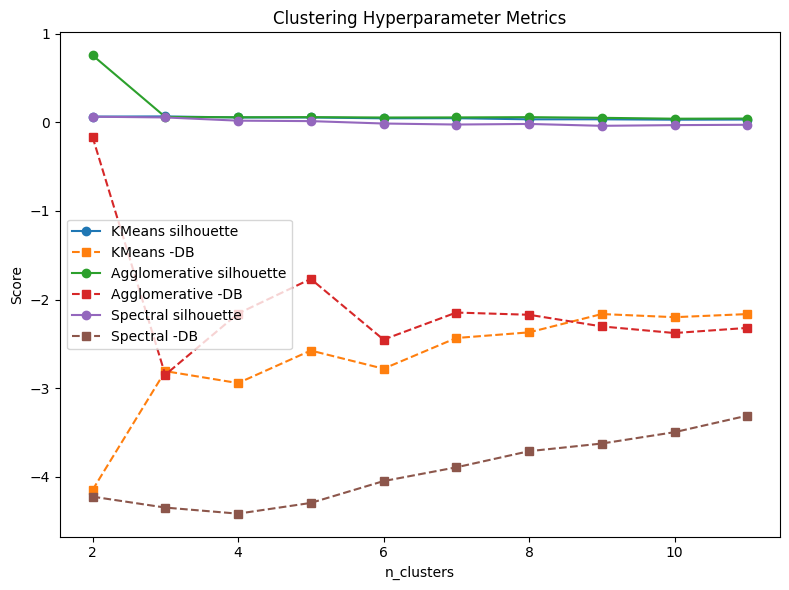

Best KMeans: k=3 (silhouette=0.066)
Best Agglomerative: k=2 (silhouette=0.756)
Best Spectral: k=2 (silhouette=0.063)
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3946 - val_loss: 0.2443
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4166 - val_loss: 0.2444
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3984 - val_loss: 0.2433
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4070 - val_loss: 0.2391
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4116 - val_loss: 0.2314
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4005 - val_loss: 0.2259
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3669 - val_loss: 0.2241
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3583 - val_loss: 0.2228
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3363 - val_loss: 0.2211
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3019 - val_loss: 0.2202
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 

/opt/homebrew/Caskroom/miniconda/base/envs/gogymi/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3781.8867 - val_loss: 3520.0051
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3528.3677 - val_loss: 3237.2549
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3071.7373 - val_loss: 2789.8979
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2527.0701 - val_loss: 2134.6450
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1852.4966 - val_loss: 1387.7607
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1009.4042 - val_loss: 848.6929
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 552.1032 - val_loss: 698.6053
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 339.4186 - val_loss: 691.4036
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 324.1911 - val_loss: 696.0707
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 255.5105 - val_loss: 700.0201
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 250.9361 - val_loss: 697.5300
Epoch 12/20
16/16 ━━━━━━━━━━━━

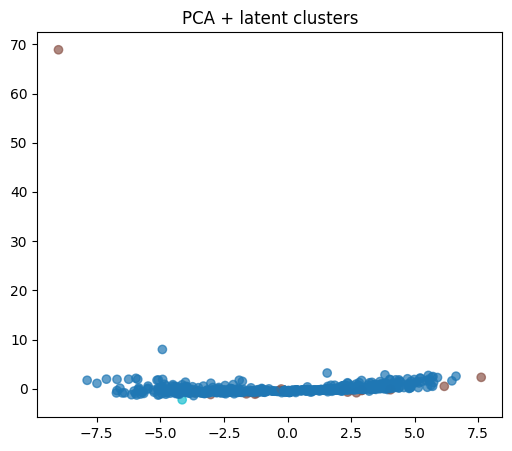

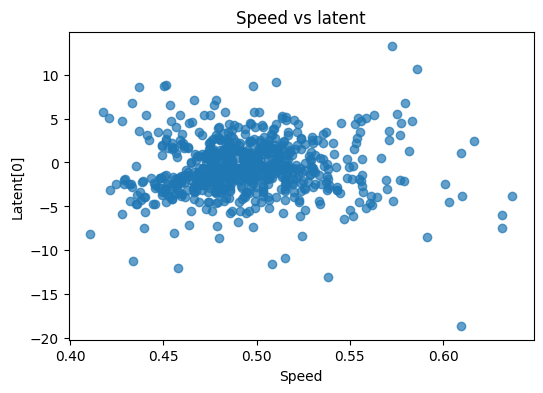

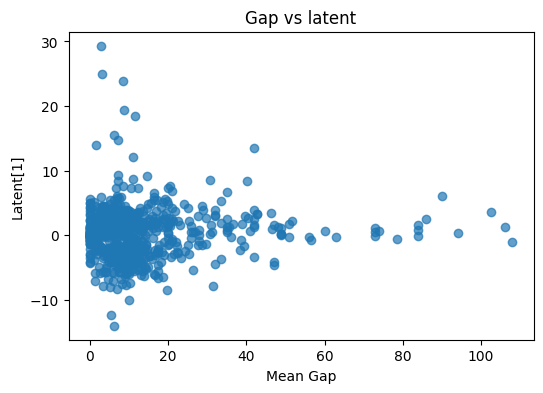

In [33]:
# %%
# Full exploratory pipeline: clustering, latent discovery, supervised validation

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform, jensenshannon
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from dtaidistance import dtw
from tensorflow.keras import layers, models, optimizers

# %%
# 0) Load data placeholders
# user_chains: dict[int, MarkovChain]
# learning_speeds: pd.DataFrame with columns ['user_id','final_learning_speed']
# gap_days: pd.DataFrame with columns ['user_id','gap_days']
# all_scores: pd.DataFrame with columns ['user_id','scores']

# %%
# 1) Feature extraction
# 1a) Markov flatten
ids = list(user_chains.keys())
markov_feats = np.vstack([user_chains[uid].to_matrix().flatten() for uid in ids])

# 1b) Learning speed (reindex to handle missing users)
spd_series = learning_speeds.set_index('user_id').reindex(ids)['final_learning_speed']
spd_series = spd_series.fillna(spd_series.median())  # impute missing with median
spd = spd_series.values.reshape(-1, 1)

# 1c) Gap summary (reindex and fill missing lists)
gap_series = gap_days.set_index('user_id').reindex(ids)['gap_days']
gap_series = gap_series.apply(lambda x: x if isinstance(x, list) else [])
gap_list = gap_series.tolist()
gap_feats = np.array([
    [np.mean(g), np.std(g), np.max(g)] if len(g) > 0 else [0.0, 0.0, 0.0]
    for g in gap_list
])

# combine features into X and standardize
X = np.hstack([markov_feats, spd, gap_feats])
X = StandardScaler().fit_transform(X)

# 2) Distance matrices
dist_markov = squareform(pdist(markov_feats, metric=lambda u, v: jensenshannon(u, v)))
dist_combined = squareform(pdist(X, metric='euclidean'))

# %%
# 3) Clustering hyperparameter sweep
# Precompute spectral affinity
dist_vals = dist_combined[np.triu_indices_from(dist_combined, k=1)]
sigma = np.median(dist_vals)
affinity_mat = np.exp(-dist_combined**2 / (2 * sigma**2))

cluster_algos = {
    'KMeans': {
        'model': KMeans,
        'args': {'random_state': 42},
        'grid': {'n_clusters': range(2, 12)}
    },
    'Agglomerative': {
        'model': AgglomerativeClustering,
        'args': {},
        'grid': {'n_clusters': range(2, 12), 'linkage': ['average']}
    },
    'Spectral': {
        'model': SpectralClustering,
        'args': {'affinity': 'precomputed', 'random_state': 42},
        'grid': {'n_clusters': range(2, 12)}
    }
}
results = {}
for name, cfg in cluster_algos.items():
    params, sil_scores, db_scores = [], [], []
    for k in cfg['grid']['n_clusters']:
        args = dict(cfg['args'], n_clusters=k)
        if name == 'Spectral':
            labels = cfg['model'](**args).fit_predict(affinity_mat)
        else:
            labels = cfg['model'](**args).fit_predict(X)
        sil = silhouette_score(X, labels)
        db = -davies_bouldin_score(X, labels)
        params.append(k)
        sil_scores.append(sil)
        db_scores.append(db)
    results[name] = {'params': params, 'sil': np.array(sil_scores), 'db': np.array(db_scores)}

# Plot metrics
plt.figure(figsize=(8, 6))
for name, res in results.items():
    plt.plot(res['params'], res['sil'], marker='o', label=f'{name} silhouette')
    plt.plot(res['params'], res['db'], marker='s', linestyle='--', label=f'{name} -DB')
plt.xlabel('n_clusters')
plt.ylabel('Score')
plt.title('Clustering Hyperparameter Metrics')
plt.legend(); plt.tight_layout(); plt.show()

# Identify best parameters
best_settings = {}
def best_param(params, scores):
    idx = np.nanargmax(scores)
    return params[idx], scores[idx]

for name, res in results.items():
    bp, bs = best_param(res['params'], res['sil'])
    best_settings[name] = (bp, bs)
    print(f"Best {name}: k={bp} (silhouette={bs:.3f})")

# %%
# 4) Latent variable discovery via autoencoder
dim_latent = 5
input_dim = X.shape[1]
inp = layers.Input(shape=(input_dim,))
enc = layers.Dense(64, activation='relu')(inp)
enc = layers.Dense(32, activation='relu')(enc)
lat = layers.Dense(dim_latent, activation='linear', name='latent')(enc)
dec = layers.Dense(32, activation='relu')(lat)
dec = layers.Dense(64, activation='relu')(dec)
out = layers.Dense(input_dim, activation='linear')(dec)
ae = models.Model(inp, out)
ae.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
ae.fit(X, X, epochs=20, batch_size=32, validation_split=0.1)
encoder = models.Model(inp, lat)
Z = encoder.predict(X)

# cluster on latent
e_k = best_settings['KMeans'][0]
labels_z = KMeans(n_clusters=e_k, random_state=42).fit_predict(Z)
print('Silhouette on latent:', silhouette_score(Z, labels_z))

# %%
# 5) Supervised regression: predict all_scores from features and latent
y_series = all_scores.set_index('user_id').reindex(ids)['scores']
y_series = y_series.fillna(y_series.median())
y = y_series.values

from sklearn.model_selection import train_test_split
Xtr, Xte, Ytr, Yte = train_test_split(np.hstack([X, Z]), y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(100, random_state=42).fit(Xtr, Ytr)
print('RF R2:', r2_score(Yte, rf.predict(Xte)))

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Xtr.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(Xtr, Ytr, epochs=20, batch_size=32, validation_split=0.1)
print('NN R2:', r2_score(Yte, model.predict(Xte).ravel()))

# %%
# 6) Visualizations for orientation
pca_coords = PCA(2).fit_transform(X)
plt.figure(figsize=(6,5))
plt.scatter(pca_coords[:,0], pca_coords[:,1], c=labels_z, cmap='tab10', alpha=0.7)
plt.title('PCA + latent clusters'); plt.show()

plt.figure(figsize=(6,4))
plt.scatter(spd, Z[:,0], alpha=0.7)
plt.xlabel('Speed'); plt.ylabel('Latent[0]'); plt.title('Speed vs latent'); plt.show()

plt.figure(figsize=(6,4))
plt.scatter(gap_feats[:,0], Z[:,1], alpha=0.7)
plt.xlabel('Mean Gap'); plt.ylabel('Latent[1]'); plt.title('Gap vs latent'); plt.show()


In [ ]:
from scipy.spatial.distance import jensenshannon
import numpy as np
import pandas as pd

# Assume user_chains is a dict: user_id -> MarkovChain object (with mc.p as transition matrix)
user_ids = list(user_chains.keys())
n_users = len(user_ids)

# Preallocate distance matrix
distance_matrix = np.zeros((n_users, n_users))

# Compute pairwise Jensen-Shannon Divergence
for i in range(n_users):
    for j in range(i + 1, n_users):
        m1 = np.array(user_chains[user_ids[i]].p)
        m2 = np.array(user_chains[user_ids[j]].p)
        
        # Flatten matrices row-wise (or you can aggregate row distributions)
        p = m1.flatten()
        q = m2.flatten()
        
        # Ensure distributions sum to 1
        if p.sum() > 0: p = p / p.sum()
        if q.sum() > 0: q = q / q.sum()
        
        jsd = jensenshannon(p, q, base=2)  # Base 2 for distance in [0, 1]
        distance_matrix[i, j] = jsd
        distance_matrix[j, i] = jsd


In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=2)
labels = clusterer.fit_predict(distance_matrix)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(distance_matrix)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], c=labels, cmap='Spectral', s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('PCA on Distance Matrix')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()


In [ ]:
import umap.umap_ as umap

umap_embedding = umap.UMAP(metric='precomputed', random_state=42).fit_transform(distance_matrix)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=labels, cmap='Spectral', s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('UMAP on Distance Matrix')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()
